In [65]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from xgboost import XGBRegressor

<h2 align="center" style="color:black">Data Loading</h2>

In [67]:
df = pd.read_excel('data/premiums_young.xlsx')

In [68]:
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


In [69]:
df.shape

(20096, 13)

In [70]:
df.columns = df.columns.str.replace(" ", "_").str.lower()

In [71]:
df.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


<h2 align="center" style="color:black">Exploratory Data Analysis & Data Cleaning</h2>

#### Handle NA Values ####

In [74]:
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [75]:
# As the number of NA values are very less like 11, 2, 13 compared to 50,000 dataset. hence we will go ahead and drop these NA values from the dataset.
df.dropna(inplace= True)

In [76]:
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [77]:
df.duplicated().sum()
# df.drop_dulpicates(inplace= True)   for future purposes
# df.duplicated().sum()


0

In [78]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267
std,2.294052,0.940713,23.420493,2749.906347
min,18.000000,-3.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


In [79]:
# Investigating the 'number_of_dependants' feature due to the presence of invalid values, such as a minimum value of -3, which is not logical.
df[df.number_of_dependants < 0].shape

(22, 13)

In [80]:
df[df.number_of_dependants < 0]['number_of_dependants'].unique()

array([-3, -1], dtype=int64)

In [81]:
df['number_of_dependants']= abs(df['number_of_dependants'])

In [82]:
df['number_of_dependants'].describe()

count    20090.000000
mean         0.722598
std          0.937200
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: number_of_dependants, dtype: float64

### Univariate Analysis: Numeric Columns

#### Box plots for numeric columns

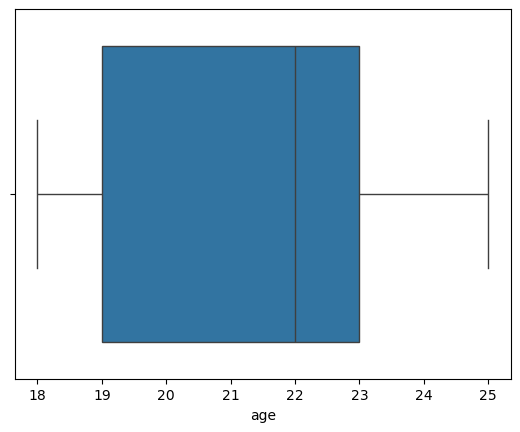

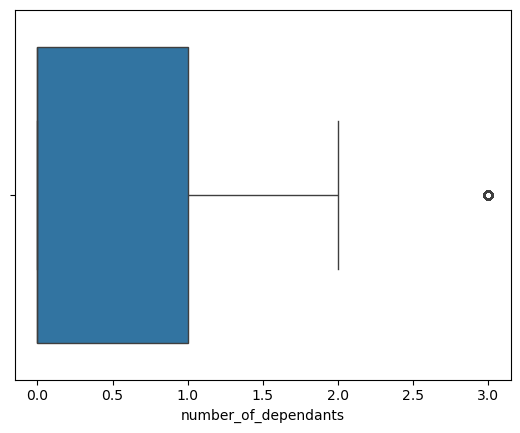

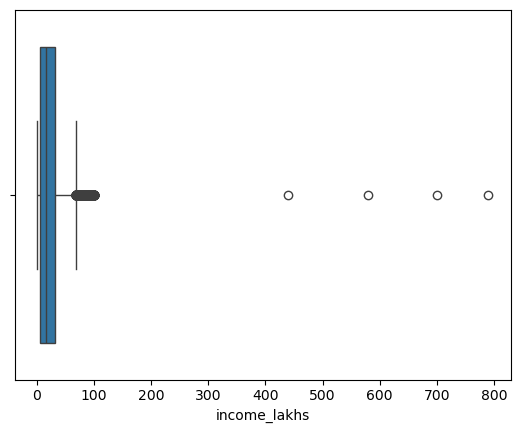

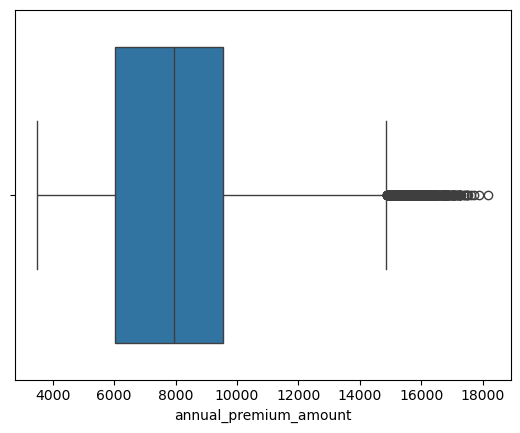

In [85]:
numeric_columns = ['age','number_of_dependants','income_lakhs',	'annual_premium_amount']

for n in numeric_columns:
    sns.boxplot(x = df[n])
    plt.show()

### Outlier Treatment: Age Column

In [87]:
df[df.age > 100].shape

(0, 13)

In [88]:
df[df.age > 100]['age'].unique()

array([], dtype=int64)

In [89]:
df1 = df[df.age<=100].copy()

In [90]:
df1.shape

(20090, 13)

In [91]:
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267
std,2.294052,0.937200,23.420493,2749.906347
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


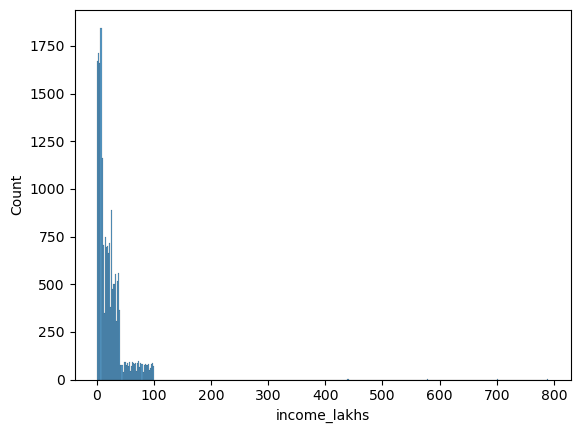

In [92]:
sns.histplot(df1.income_lakhs)
plt.show()

### Outlier Treatment: Income Column

In [94]:
def get_iqr_bounds(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5* IQR
    upper = Q3 + 1.5* IQR
    return lower, upper

In [95]:
get_iqr_bounds(df1.income_lakhs)

(-31.5, 68.5)

In [96]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

100.0

In [97]:
df1[df1['income_lakhs'] > quantile_threshold].shape

(4, 13)

In [98]:
df2 = df1[df1['income_lakhs'] <= quantile_threshold]
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20086.000000,20086.000000,20086.000000,20086.000000
mean,21.494474,0.722742,22.390371,8141.799263
std,2.294248,0.937238,21.732062,2749.912486
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.000000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,100.000000,18186.000000


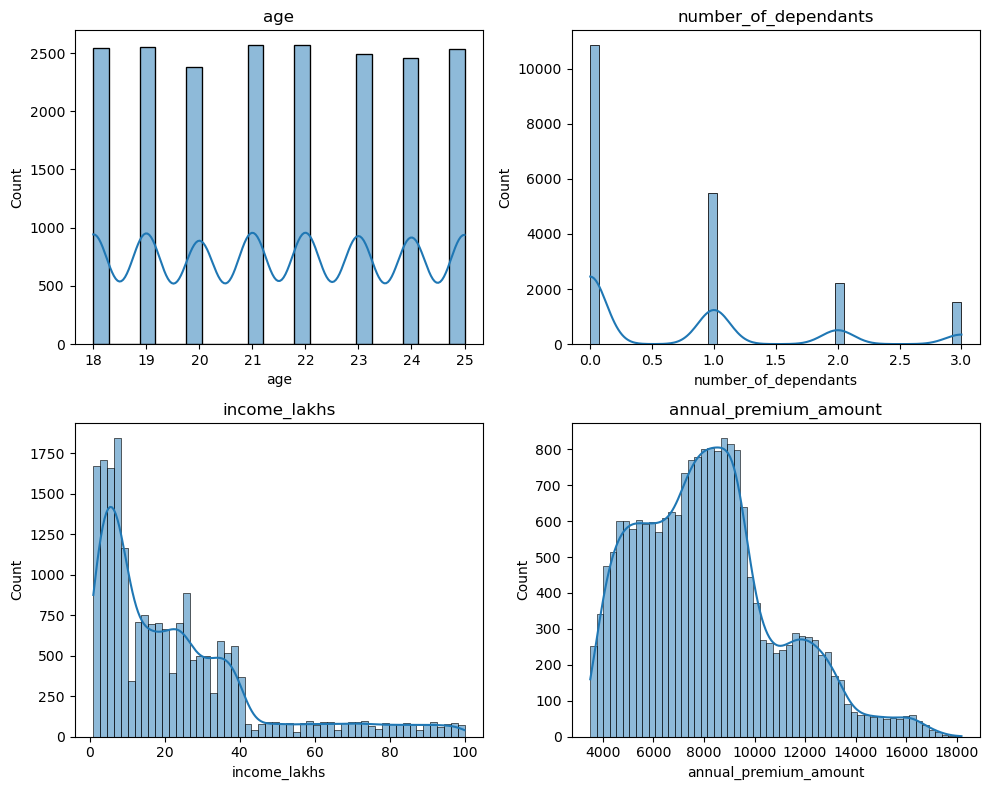

In [99]:
fig , axs = plt.subplots(nrows= 2, ncols= 2, figsize= (10,8))

for i, col in enumerate(numeric_columns):
    ax = axs[i//2, i%2]
    sns.histplot(df2[col], kde = True, ax= ax)
    ax.set_title(col)

plt.tight_layout()
plt.show()

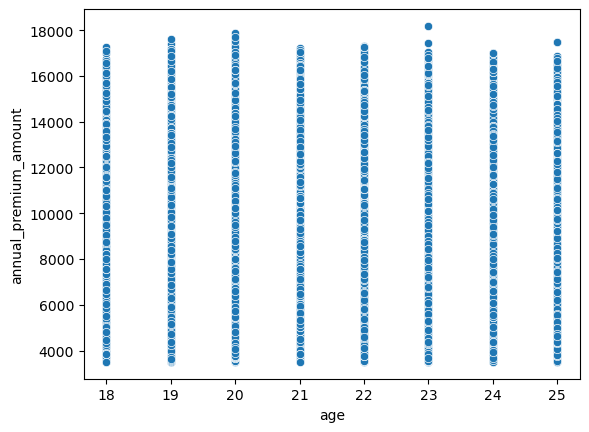

In [100]:
sns.scatterplot(df2, x = 'age', y= 'annual_premium_amount')
plt.show()

### Bivariate Analysis: Numeric Columns

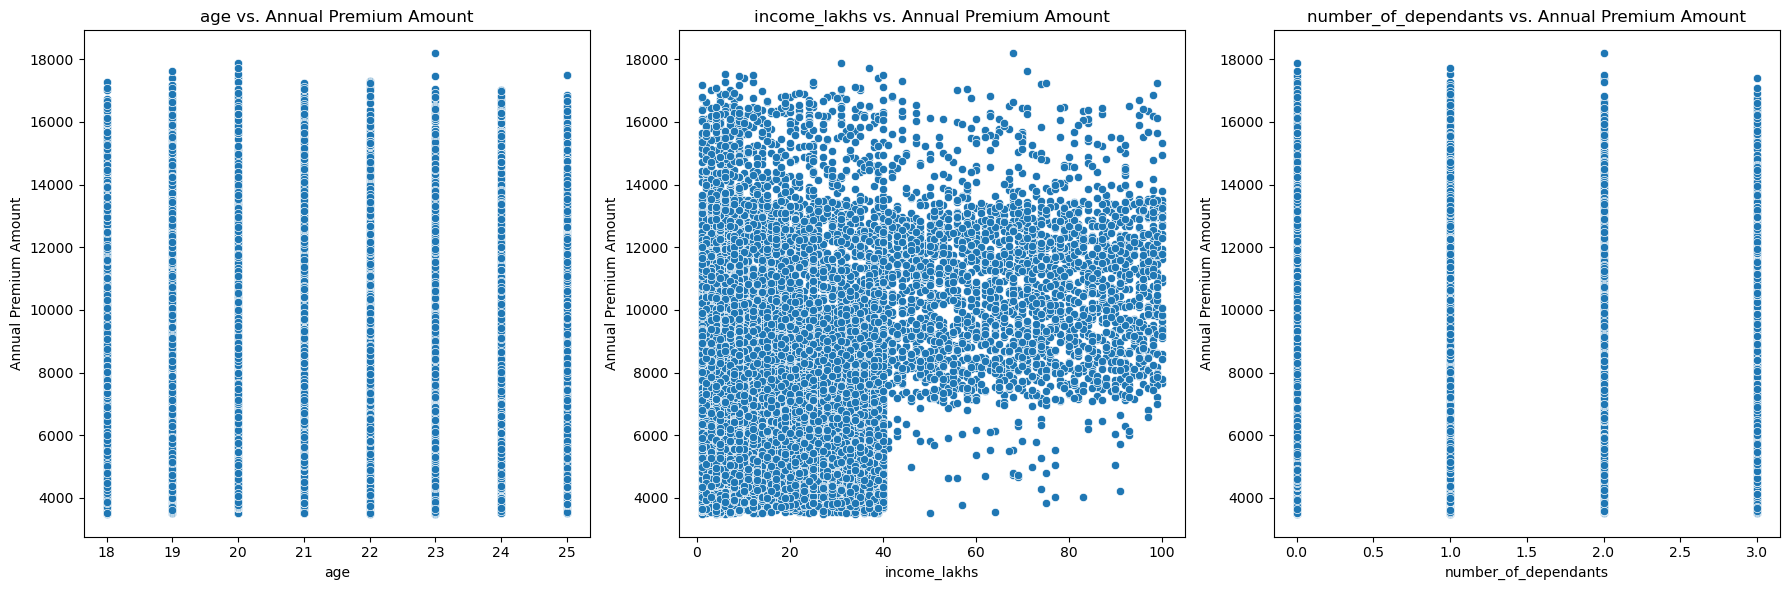

In [102]:
numeric_features = ['age', 'income_lakhs', 'number_of_dependants']

fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 6))  # Adjust figure size as necessary

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x=df2[column], y=df2['annual_premium_amount'], ax=ax)
    ax.set_title(f'{column} vs. Annual Premium Amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()  # Adjust layout
plt.show()

## 2. Categorical Columns

In [104]:
categorical_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']

for col in categorical_cols:
    print(col, ":", df2[col].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


In [105]:
df2['smoking_status'].replace({
    'Smoking=0': 'No Smoking',
    'Does Not Smoke': 'No Smoking',
    'Not Smoking': 'No Smoking',
}, inplace= True)

df2['smoking_status'].unique()

C:\Users\aksha\AppData\Local\Temp\ipykernel_18988\2312702400.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['smoking_status'].replace({
C:\Users\aksha\AppData\Local\Temp\ipykernel_18988\2312702400.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['smoking_status'].replace({


array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

In [106]:
per_count= df2.gender.value_counts(normalize= True)

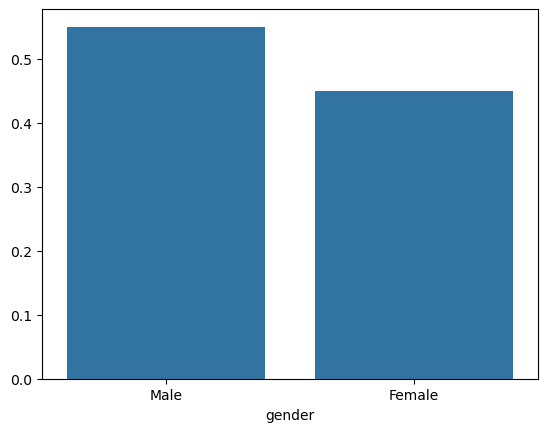

In [107]:
sns.barplot(x= per_count.index, y = per_count.values)
plt.show()

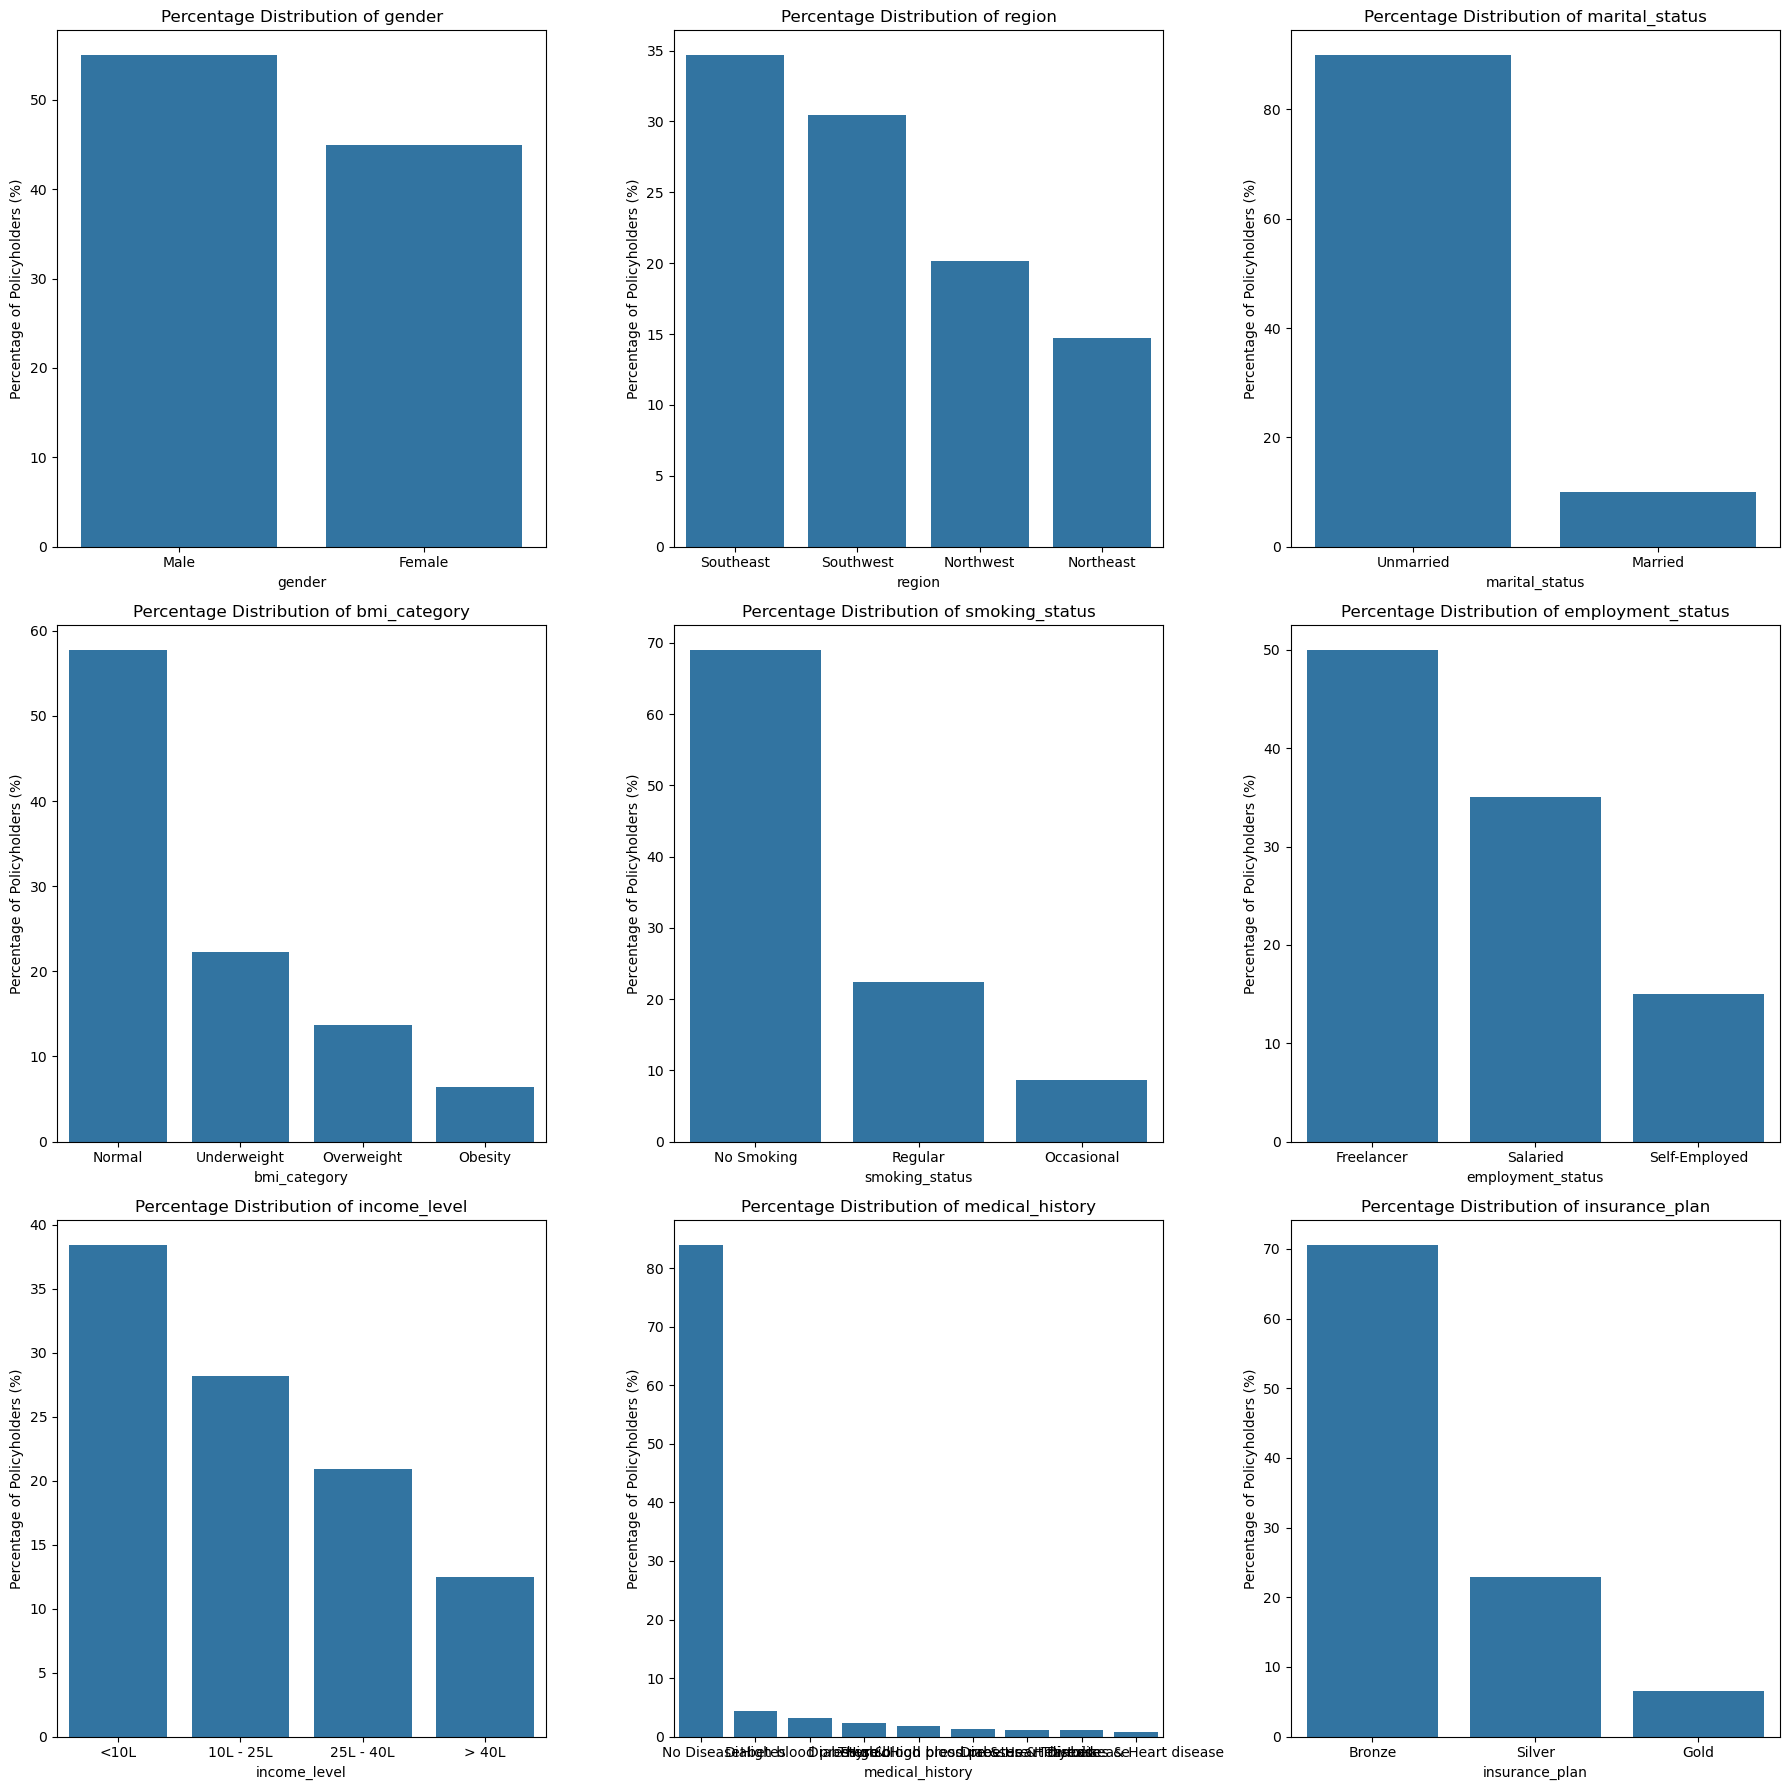

In [108]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))  # Adjust figure size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for ax, column in zip(axes, categorical_cols):
    # Calculate the percentage distribution of each category
    category_counts = df2[column].value_counts(normalize=True) * 100  # normalize=True gives the relative frequencies
    
    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel('Percentage of Policyholders (%)')
    ax.set_xlabel(column)  # Set xlabel to the column name for clarity

plt.tight_layout()  # Adjusts plot parameters for better fit in the figure window
plt.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         4508   326     828
25L - 40L         3382   209     608
<10L              6172   404    1145
> 40L              115   366    2023


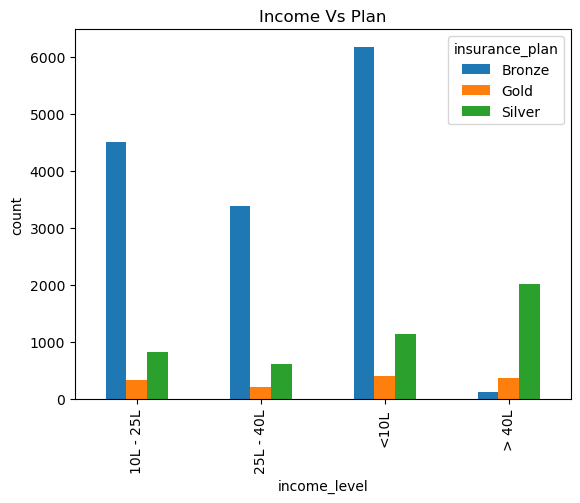

In [109]:
cross_tab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
print(cross_tab)

cross_tab.plot(kind='bar')
plt.title('Income Vs Plan')
plt.ylabel('count')
plt.show()

<h2 align="center" style="color:black">Feature Engineering</h2>

In [111]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


In [112]:
df2.medical_history.unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

#### Calculate Risk Score ####

In [114]:
# Define the risk scores for each condition
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df2[['disease1', 'disease2']] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

# Normalize the risk score to a range of 0 to 1
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head(2)

C:\Users\aksha\AppData\Local\Temp\ipykernel_18988\59644619.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[['disease1', 'disease2']] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
C:\Users\aksha\AppData\Local\Temp\ipykernel_18988\59644619.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[['disease1', 'disease2']] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
C:\Users\aksha\AppData\Local\Temp\ipykernel_18988\596446

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,none,0,0.000000


### Encode Text Columns

In [116]:
df.insurance_plan.unique()

array(['Silver', 'Bronze', 'Gold'], dtype=object)

In [117]:
df2['insurance_plan']= df2['insurance_plan'].map({'Bronze': 1, 'Silver':2, 'Gold':3})
df2.head()

C:\Users\aksha\AppData\Local\Temp\ipykernel_18988\225839174.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['insurance_plan']= df2['insurance_plan'].map({'Bronze': 1, 'Silver':2, 'Gold':3})


,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,2,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,2,11050,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,2,11857,no disease,none,0,0.000000
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,1,5684,no disease,none,0,0.000000
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,1,5712,no disease,none,0,0.000000


In [118]:
df.income_level.unique()

array(['> 40L', '<10L', '10L - 25L', '25L - 40L'], dtype=object)

In [119]:
df2['income_level']= df2['income_level'].map({'<10L': 1, '10L - 25L':2, '> 40L':3, '25L - 40L':4})
df2.head()

C:\Users\aksha\AppData\Local\Temp\ipykernel_18988\4207077798.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['income_level']= df2['income_level'].map({'<10L': 1, '10L - 25L':2, '> 40L':3, '25L - 40L':4})


,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,3,99,High blood pressure,2,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,1,3,No Disease,2,11050,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,3,97,No Disease,2,11857,no disease,none,0,0.000000
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,2,15,No Disease,1,5684,no disease,none,0,0.000000
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,2,14,No Disease,1,5712,no disease,none,0,0.000000


In [120]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3= pd.get_dummies(df2, columns= nominal_cols, drop_first= True, dtype=int)
df3.head(2)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,3,99,High blood pressure,2,13365,high blood pressure,none,6,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,no disease,none,0,...,0,0,1,0,0,1,0,0,0,0


### Feature Selection

In [122]:
df4 = df3.drop(['medical_history','disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head(3) 

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,3,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,3,97,2,11857,0.000000,0,0,1,0,1,0,0,0,0,1,1,0


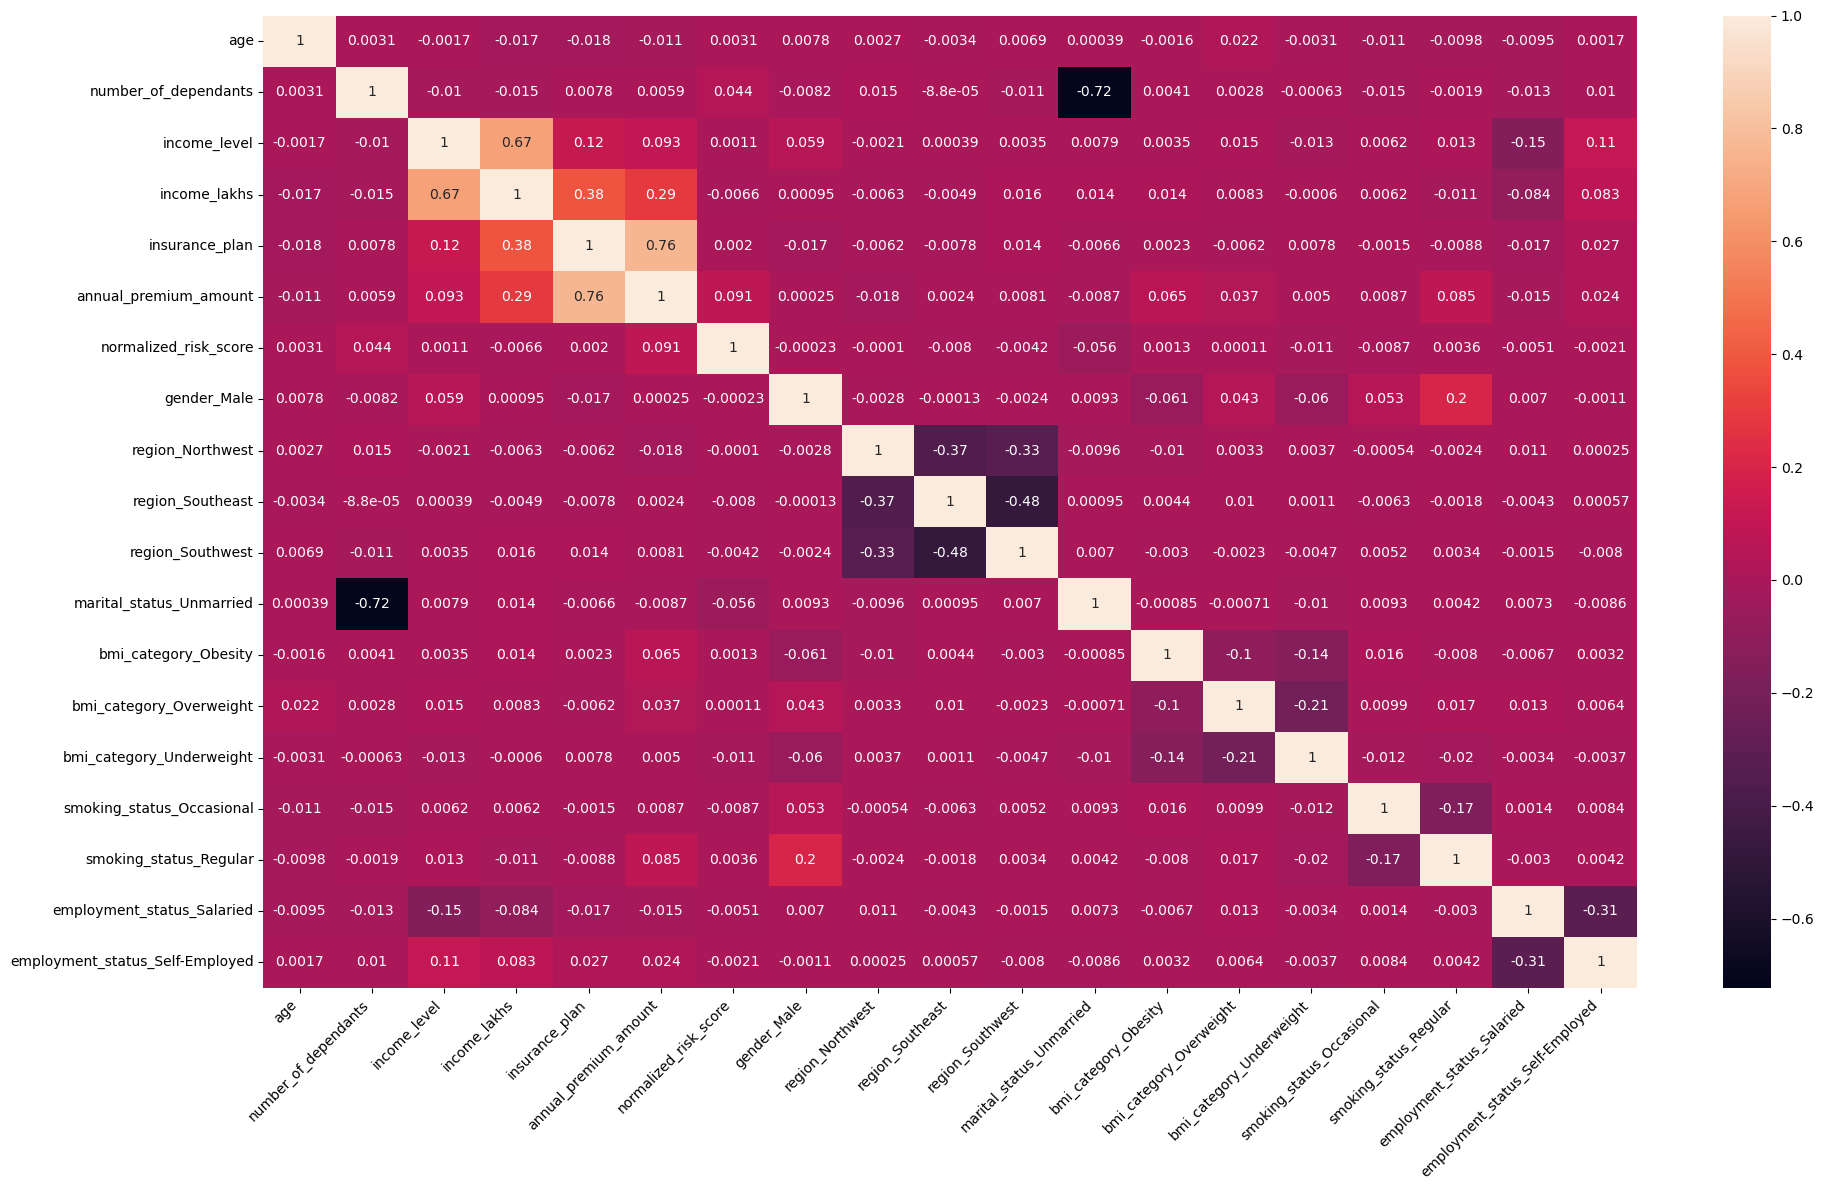

In [123]:
cm = df4.corr()

plt.figure(figsize= (20,12))
sns.heatmap(cm, annot= True)
plt.xticks(rotation = 45, ha = 'right')
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

In [124]:
X = df4.drop('annual_premium_amount', axis= 'columns')
y = df4['annual_premium_amount']

cols_to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan']
scaler= MinMaxScaler()
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,0.499211,0.240914,0.386123,0.216064,0.179578,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.063527,0.136513,0.222493,0.086379,0.223589,0.350045,0.149955
std,0.327750,0.312413,0.383007,0.219516,0.300051,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.243914,0.343341,0.415931,0.280929,0.416660,0.476996,0.357036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.050505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.571429,0.000000,0.333333,0.151515,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.666667,0.303030,0.500000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [125]:
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [126]:
calculate_vif(X)

,Column,VIF
0,age,3.144224
1,number_of_dependants,1.867394
2,income_level,3.915844
3,income_lakhs,4.343596
4,insurance_plan,1.647480
5,normalized_risk_score,1.154461
6,gender_Male,2.317166
7,region_Northwest,2.148426
8,region_Southeast,2.971750
9,region_Southwest,2.731418


<h2 align="center" style="color:black">Model Training</h2>

In [128]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.3, random_state= 10)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(14060, 18)
(6026, 18)
(14060,)
(6026,)


### Linear Regression Model

In [130]:
model_lr= LinearRegression()
model_lr.fit(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score = model_lr.score(X_train, y_train)
train_score, test_score

(0.6021300813076781, 0.6046339581365334)

In [131]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr= np.sqrt(mse_lr)
print(mse_lr, rmse_lr)

3006620.1428291835 1733.9608250560864


In [132]:
model_lr.coef_

array([ 5.55705130e+01, -1.44942755e+02, -9.13626682e+01,  8.02725510e+01,
        6.98222929e+03,  1.11267515e+03,  1.36660842e+01, -1.15033538e+02,
       -3.72576728e+01, -6.83963588e+01, -5.92445388e+01,  7.92256313e+02,
        4.36364902e+02,  1.69069952e+02,  2.45315349e+02,  6.19957762e+02,
       -1.87660749e+01, -5.79465521e-01])

In [133]:
model_lr.intercept_

6628.345150370236

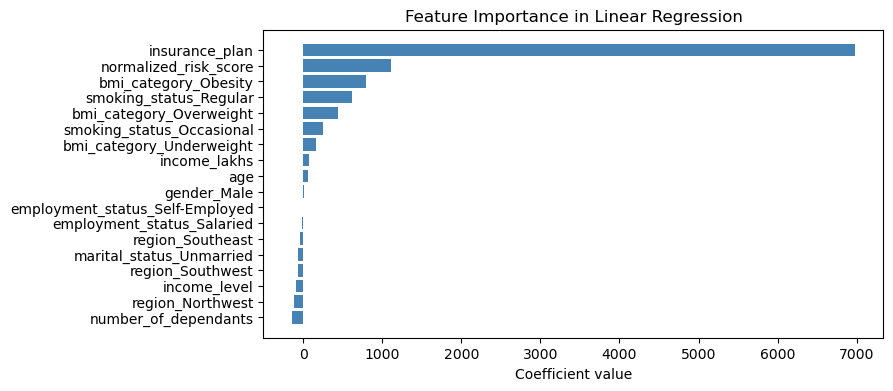

In [134]:
feature_importances = model_lr.coef_

coef_df = pd.DataFrame(feature_importances, index = X_test.columns, columns= ['Coefficients'])
coef_df = coef_df.sort_values(by= 'Coefficients', ascending= True)
coef_df

plt.figure(figsize = (8,4))
plt.barh(coef_df.index, coef_df['Coefficients'], color= 'steelblue')
plt.xlabel('Coefficient value')
plt.title('Feature Importance in Linear Regression')
plt.show()

### Ridge Regression Model

In [136]:
model_ridge = Ridge(alpha= 10)
model_ridge.fit(X_train, y_train)
test_score_ridge = model_ridge.score(X_test, y_test)
train_score_ridge = model_ridge.score(X_train, y_train)
train_score_ridge, test_score_ridge

(0.6020846699455917, 0.6046902561962708)

### XGBoost 

In [138]:
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
test_score_xgb = model_xgb.score(X_test, y_test)
train_score_xgb = model_xgb.score(X_train, y_train)
train_score_xgb, test_score_xgb

(0.7257862091064453, 0.5618709921836853)

In [139]:
y_pred = model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb= np.sqrt(mse_xgb)
print(mse_xgb, rmse_xgb)

3331817.5651739608 1825.3267009425904


In [140]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=15, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_

0.5996079444885254

In [141]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}

In [142]:
best_model = random_search.best_estimator_
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

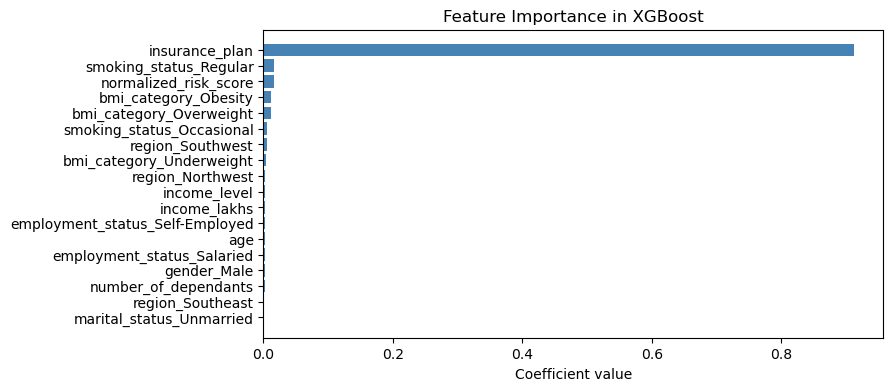

In [143]:
feature_importances = best_model.feature_importances_

coef_df = pd.DataFrame(feature_importances, index = X_test.columns, columns= ['Coefficients'])
coef_df = coef_df.sort_values(by= 'Coefficients', ascending= True)
coef_df

plt.figure(figsize = (8,4))
plt.barh(coef_df.index, coef_df['Coefficients'], color= 'steelblue')
plt.xlabel('Coefficient value')
plt.title('Feature Importance in XGBoost')
plt.show()

#### Error Analysis

In [145]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = residuals * 100 / y_test

results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'diff': residuals,
    'diff_pct': residuals_pct
})
results_df

,actual,predicted,diff,diff_pct
12774,6238,6668.446777,430.446777,6.900397
14758,9462,7004.729492,-2457.270508,-25.969885
13205,5152,7000.442383,1848.442383,35.878152
14278,6988,7870.067871,882.067871,12.622608
19351,4917,6676.775391,1759.775391,35.789615
...,...,...,...,...
17652,7635,6575.510254,-1059.489746,-13.876748
5807,4845,7059.707031,2214.707031,45.711187
10298,13866,11000.165039,-2865.834961,-20.668073
13316,5255,6676.775391,1421.775391,27.055669


<Axes: xlabel='diff_pct', ylabel='Count'>

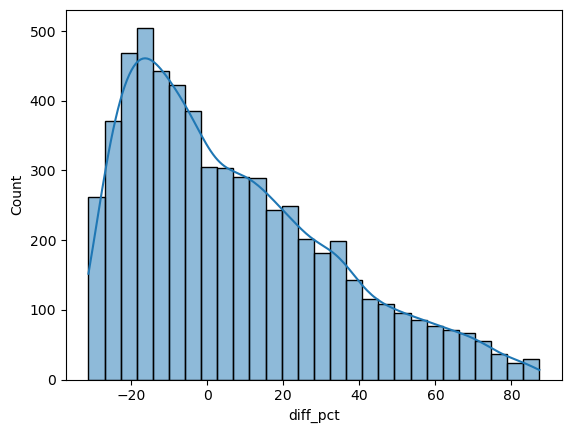

In [146]:
sns.histplot(results_df['diff_pct'], kde= True)

In [147]:
extreme_error_threshold = 10
extreme_results_df = results_df[np.abs(results_df.diff_pct) > extreme_error_threshold]
extreme_results_df.shape

(4399, 4)

In [148]:
extreme_error_pct = extreme_results_df.shape[0] * 100/ results_df.shape[0]
extreme_error_pct

73.00033189512114

In [149]:
results_df[np.abs(results_df.diff_pct) > 50].sort_values(by='diff_pct', ascending= False)


,actual,predicted,diff,diff_pct
4169,3517,6588.291992,3071.291992,87.327040
4692,3516,6575.971680,3059.971680,87.029911
12285,3532,6592.579102,3060.579102,86.652862
16580,3538,6592.579102,3054.579102,86.336323
3652,3536,6575.510254,3039.510254,85.959000
...,...,...,...,...
405,4659,6992.759277,2333.759277,50.091420
4017,4707,7063.994141,2356.994141,50.074233
9356,5198,7797.806641,2599.806641,50.015518
1597,4653,6979.977539,2326.977539,50.010263


In [150]:
extreme_errors_df= X_test.loc[extreme_results_df.index]
extreme_errors_df

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
14758,0.285714,0.000000,0.000000,0.060606,0.0,0.000000,0,0,0,1,1,0,0,0,0,1,0,1
13205,0.714286,0.333333,0.333333,0.141414,0.0,0.000000,1,1,0,0,1,0,0,0,0,1,0,1
14278,0.714286,0.333333,0.333333,0.222222,0.0,0.000000,1,0,1,0,1,1,0,0,0,1,0,0
19351,0.571429,0.000000,0.333333,0.101010,0.0,0.000000,1,0,0,1,1,0,0,1,0,0,0,0
10622,0.428571,0.333333,0.000000,0.050505,0.0,0.357143,0,0,1,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,0.142857,0.666667,0.333333,0.111111,0.0,0.785714,0,0,0,1,1,0,0,1,0,0,1,0
17652,0.571429,0.000000,1.000000,0.343434,0.0,0.000000,1,0,0,0,1,0,0,0,0,0,1,0
5807,0.857143,0.333333,0.000000,0.040404,0.0,0.000000,1,1,0,0,1,0,0,0,0,1,0,0
10298,0.000000,0.000000,0.333333,0.111111,0.5,0.000000,1,0,1,0,1,0,1,0,0,1,1,0


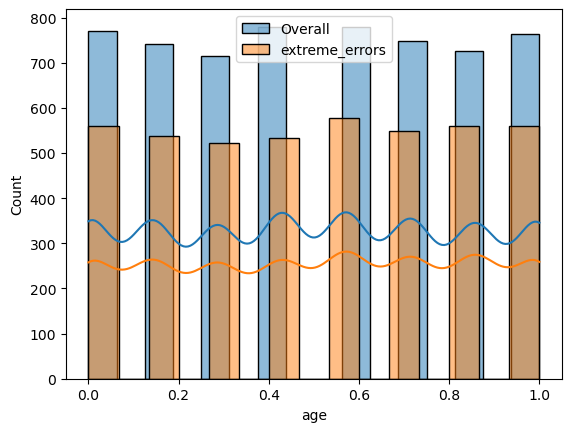

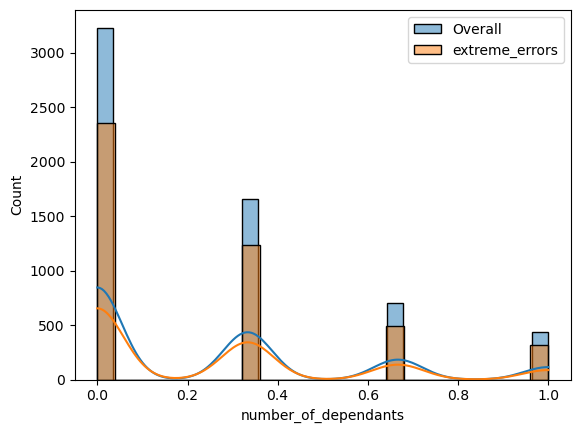

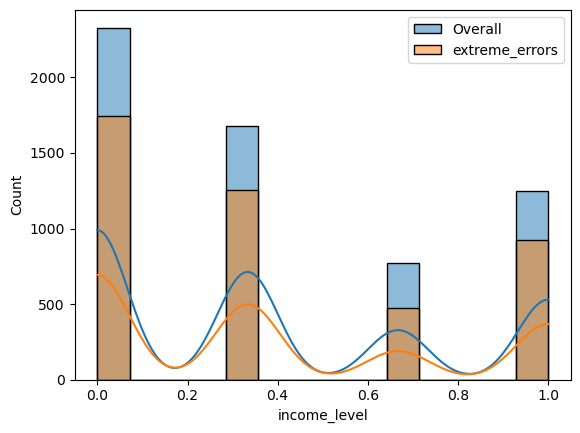

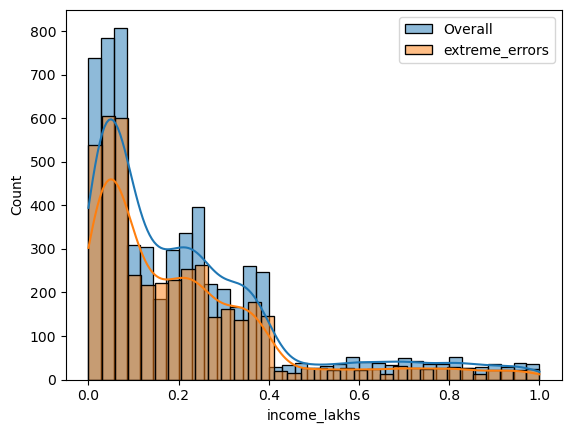

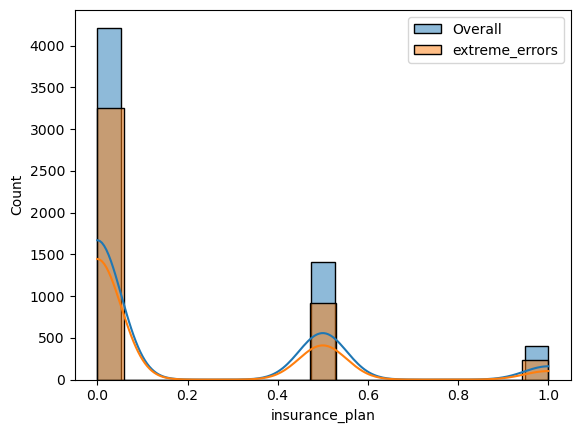

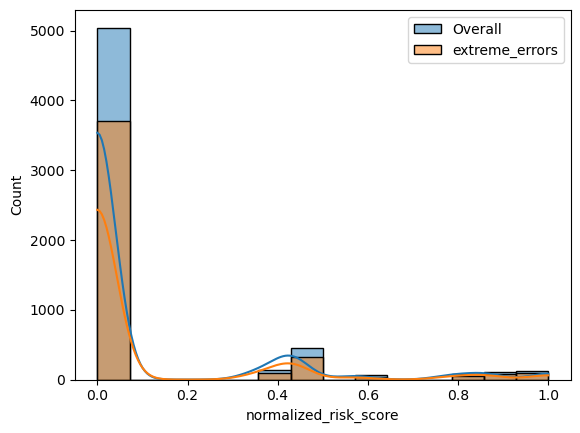

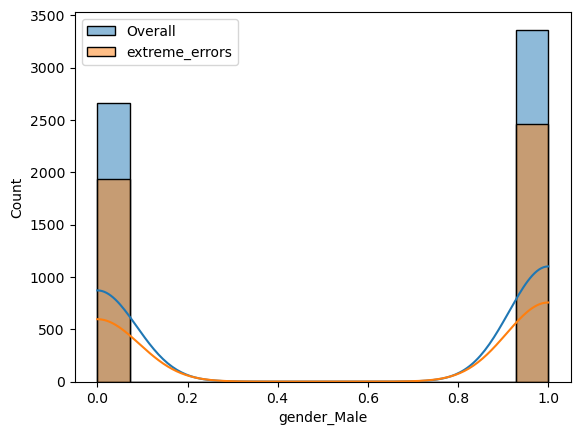

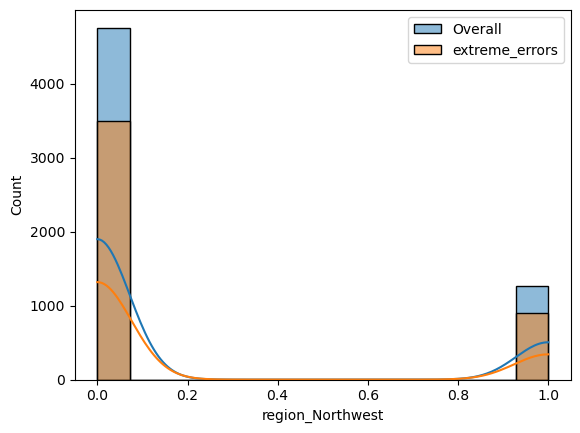

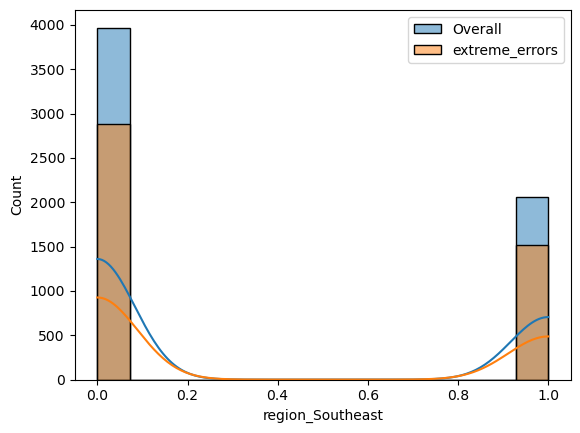

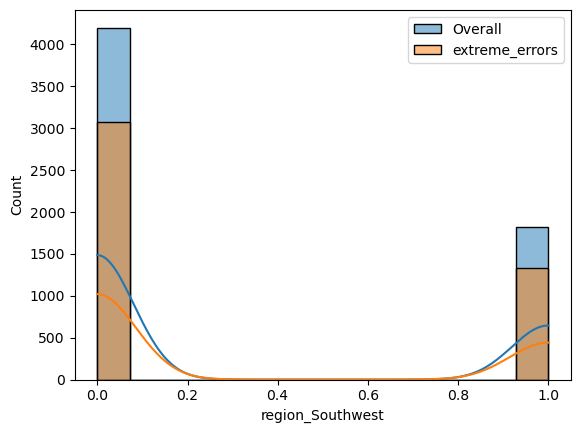

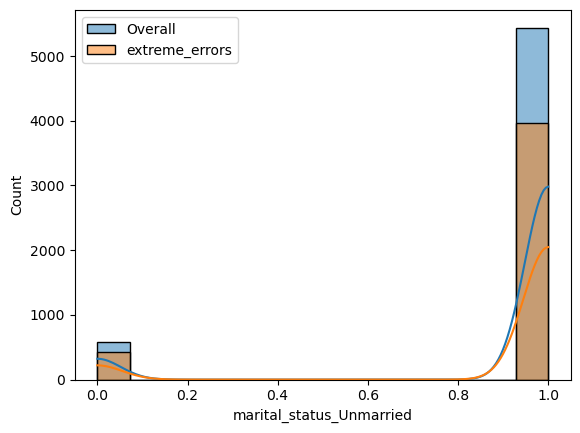

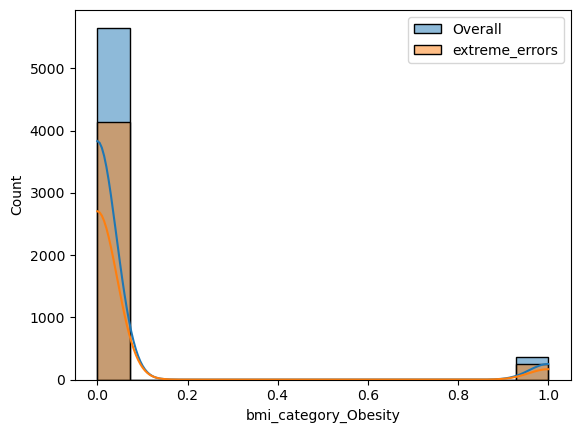

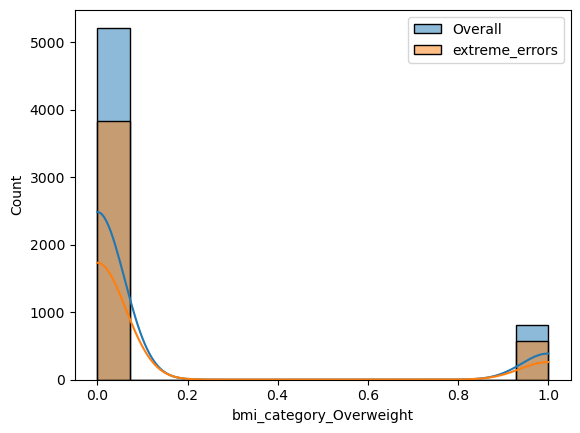

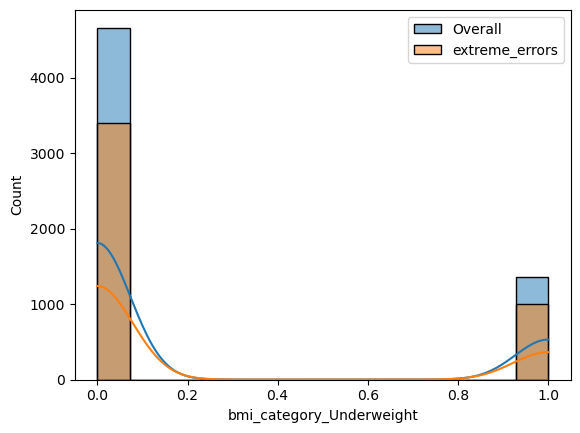

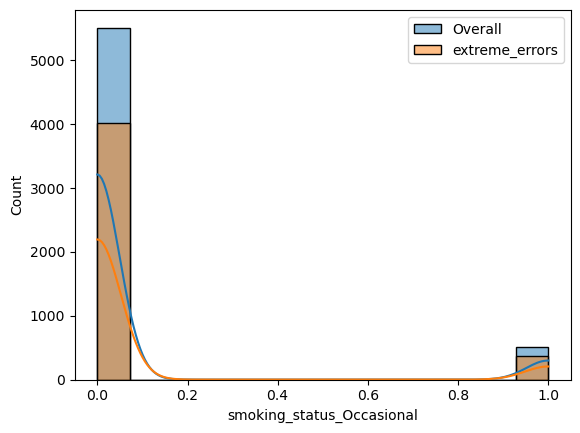

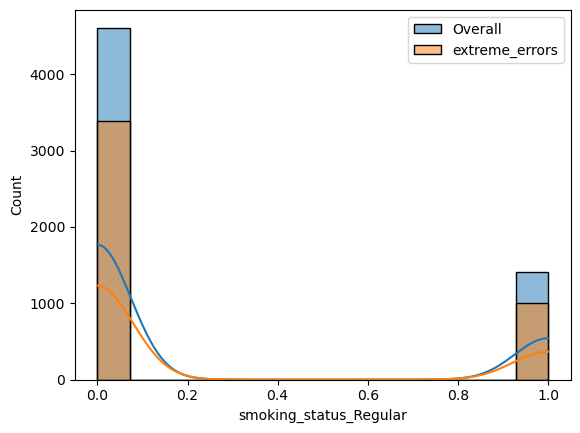

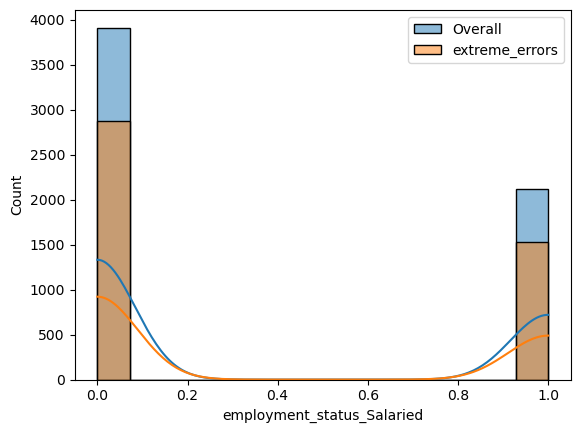

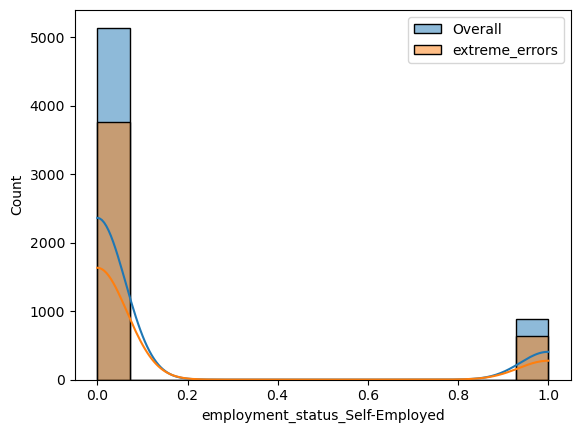

In [151]:
for feature in X.columns:
    sns.histplot(X_test[feature], label = "Overall", kde= True)
    sns.histplot(extreme_errors_df[feature], label = 'extreme_errors',  kde= True)
    plt.legend()
    plt.show()

In [152]:
df_reversed= pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,20.0,0.0,1.0,7.0,1.0
1,23.0,1.0,2.0,15.0,1.0
2,23.0,1.0,2.0,23.0,1.0
3,22.0,0.0,2.0,11.0,1.0
4,21.0,1.0,1.0,6.0,1.0
...,...,...,...,...,...
4394,19.0,2.0,2.0,12.0,1.0
4395,22.0,0.0,4.0,35.0,1.0
4396,24.0,1.0,1.0,5.0,1.0
4397,18.0,0.0,2.0,12.0,2.0


<Axes: xlabel='age', ylabel='Count'>

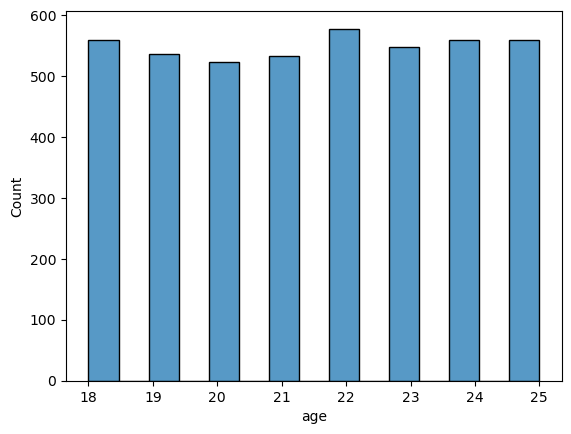

In [153]:
sns.histplot(df_reversed.age)

In [154]:
df_reversed['age'].quantile(0.95)

25.0